In [1]:
!pip install matplotlib
!pip install numpy
!pip install seaborn
!pip install tqdm
!pip install gymnasium==0.27.0
!pip install gymnasium[toy_text]
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Installing necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict #allows access to undefined keys

import warnings
warnings.filterwarnings("ignore")
import gymnasium as gym

/usr/local/lib/python3.10/dist-packages/jax/_src/deprecations.py:51: DeprecationWarning: jax.numpy.DeviceArray is deprecated. Use jax.Array.
  warnings.warn(message, DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/jax/_src/deprecations.py:51: DeprecationWarning: jax.numpy.DeviceArray is deprecated. Use jax.Array.
  warnings.warn(message, DeprecationWarning)


In [3]:
# Creating a Blackjack environment
env = gym.make("Blackjack-v1", sab=True, render_mode="rgb_array")

done = False
observation,info = env.reset()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# Sample a random action from all valid actions
action = env.action_space.sample()

# Execute the action in the environment and receive information
observation, reward, terminated, truncated, info = env.step(action)

In [5]:
#Initializing a Reinforcement Learning agent with an empty dictionaryof state-action values (q_values), a learning rate and an epsilon
class BlackjackAgent:
    def __init__(self, learning_rate, initial_epsilon, epsilon_decay, final_epsilon, discount_factor=0.95):
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
        self.lr = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.training_error = []

    def get_action(self, obs):
# with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()
# with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(self, obs, action, reward, terminated, next_obs):
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        self.q_values[obs][action] += self.lr * temporal_difference
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)


In [6]:
# implying hyperparameters
learning_rate = 0.01
n_episodes = 1000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

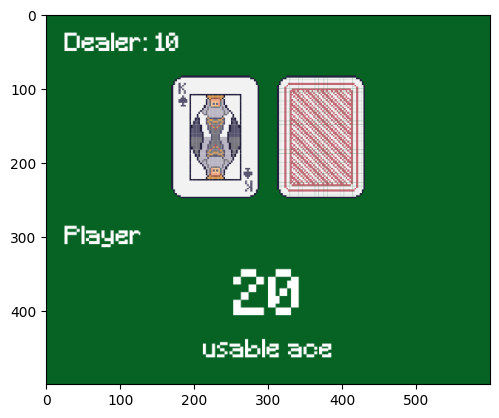

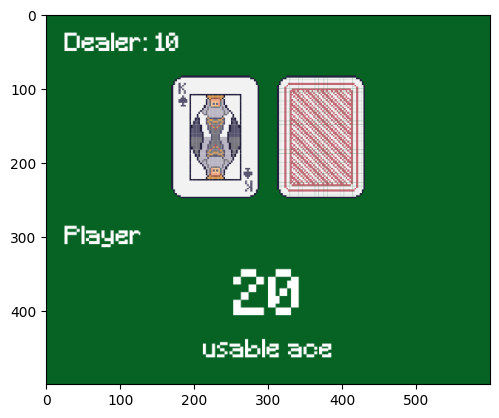

100%|██████████| 1000/1000 [06:56<00:00,  2.40it/s]


In [7]:
#clearing the output after one episode so that it does not effect other episodes
from IPython.display import clear_output
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    clear_output()

 # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
# update the agent
        agent.update(obs, action, reward, terminated, next_obs)
        frame = env.render()
        plt.imshow(frame)
        plt.show()
# update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

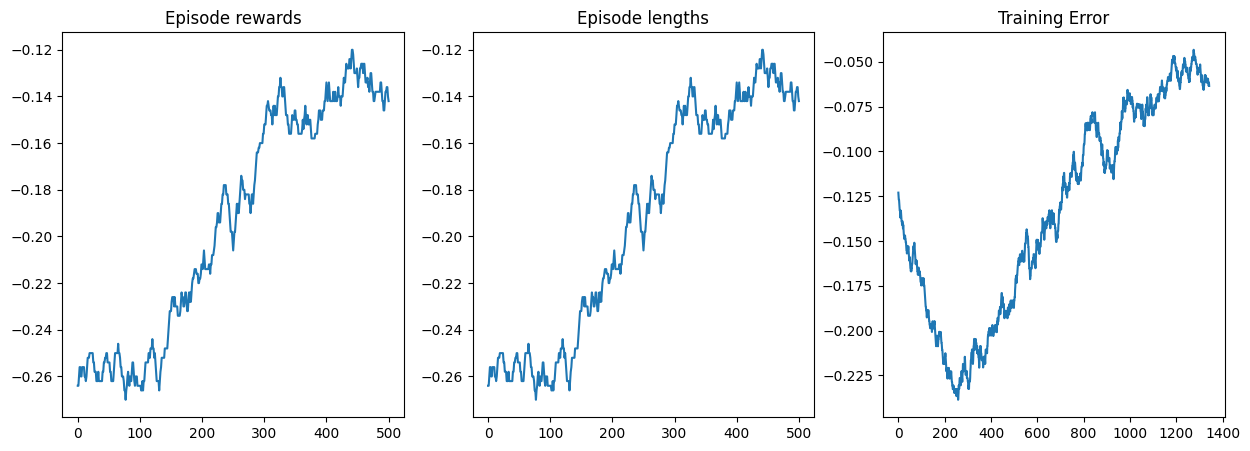

In [8]:
# with the help of matplotlib creating visualization which will help to understand the difference in learing of the agent
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
axs[0].set_title("Episode rewards")
reward_moving_average = np.convolve(np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid") / rolling_length
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

axs[1].set_title("Episode lengths")
length_moving_average = np.convolve(np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid") / rolling_length
axs[1].plot(range(len(length_moving_average)), length_moving_average)

axs[2].set_title("Training Error")
training_error_moving_average = np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)